# [Assignment 2](https://ovgu-ailab.github.io/idl2023/assignment2.html)

**_Colaborative Work from Adrian Bremer and Philipp Reinig_**

## Setup

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-10-20 11:41:04.307369: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-20 11:41:04.351850: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-20 11:41:04.351910: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-20 11:41:04.351961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-20 11:41:04.362063: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-20 11:41:04.363367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## MLP from assignment 1

In [16]:
class MLP:
    
    def __init__(self, layer_sizes, init_val):
        if len(layer_sizes) <= 1:
            raise AssertionError("There has to be at least 2 layers. 'layer_sizes' was {}".format(layer_sizes))
        
        self.weights = [tf.Variable(np.random.uniform(low=-init_val, high=init_val, size=(layer_sizes[i], layer_sizes[i+1])).astype(np.float32)) for i in range(len(layer_sizes)-1)]
        self.biases = [tf.Variable(np.zeros(layer_sizes[i]).astype(np.float32)) for i in range(1,len(layer_sizes))]
    
    def model(self, input_batch):
        """returns the logits for a given input batch"""
        
        n = len(self.biases)
        if n == 1:
            return tf.matmul(input_batch, self.weights[0]) + self.biases[0]
        
        next_input = input_batch
        for i in range(n-1):
            next_input = tf.nn.leaky_relu(tf.matmul(next_input, self.weights[i]) + self.biases[i])
        
        return tf.matmul(next_input, self.weights[n-1]) + self.biases[n-1]
    
    def train(self, imgs, lbls, learning_rate):
        """returns the cross entropy error"""
        n = len(self.biases)
      
        with tf.GradientTape() as tape:
            logits = self.model(imgs)
            xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits, labels=lbls))
        
        grads = tape.gradient(xent, self.weights + self.biases)
        for i in range(n):
            self.weights[i].assign_sub(learning_rate * grads[i])
            self.biases[i].assign_sub(learning_rate * grads[n+i])
        
        return xent
            
            

## Datasets
### Shuffle, batch, repeat

- **shuffle** - reorders the dataset uniformly at random
- **batch** - produces a dataset that has batches
- **repeat** - repeats the dataset the given amount of times or indefinitly -> when the dataset ends it wraps around

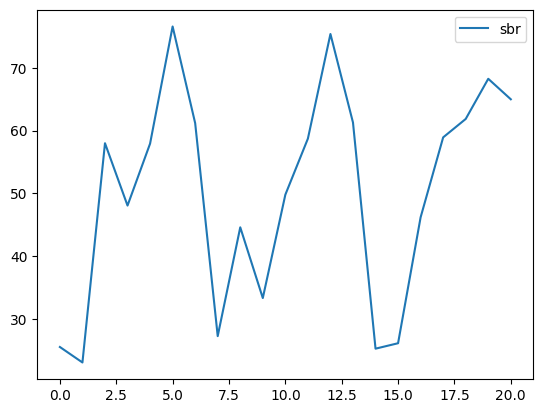

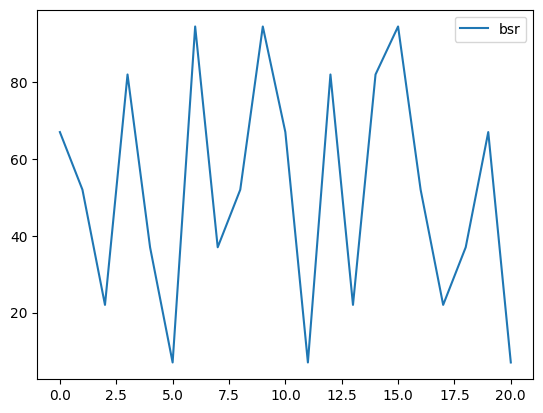

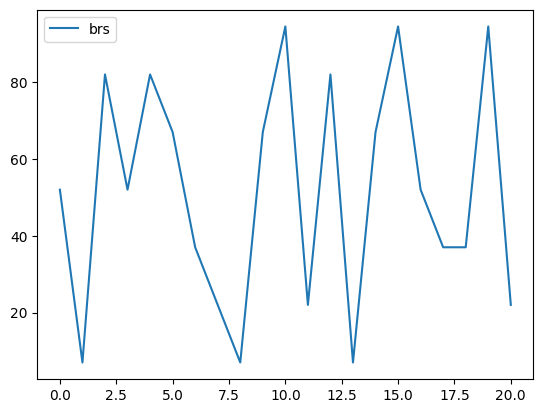

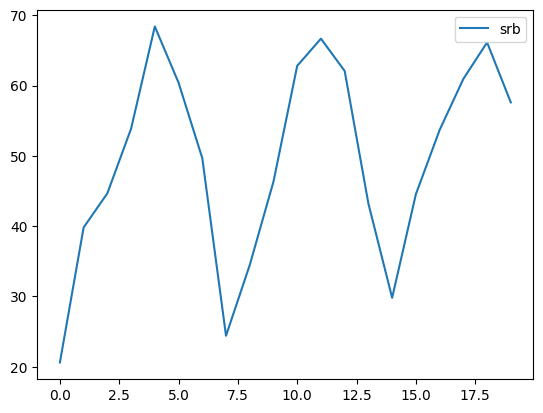

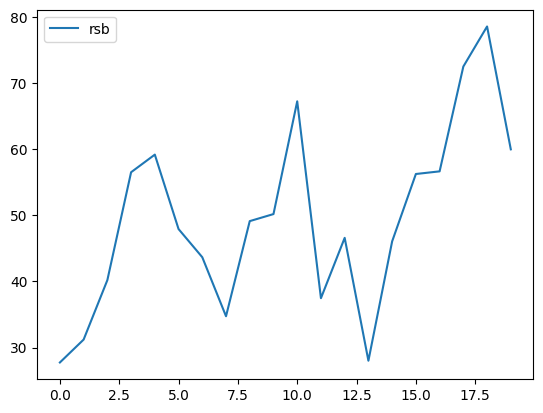

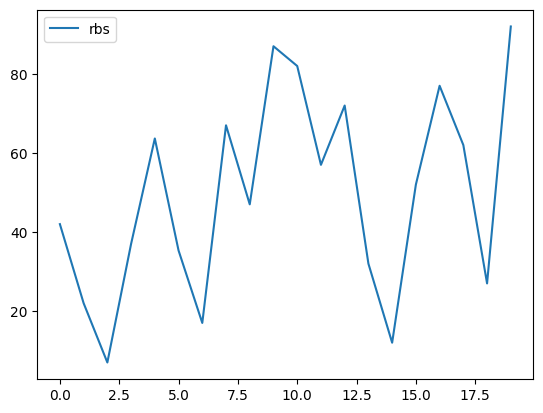

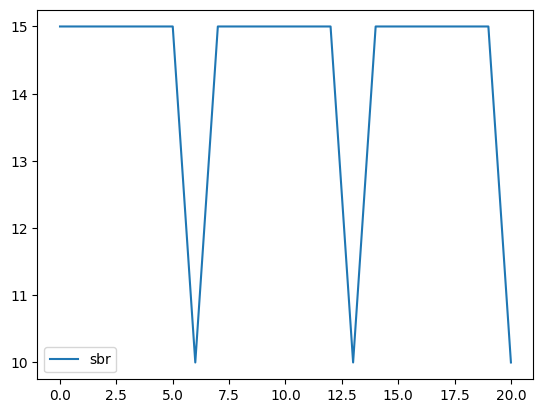

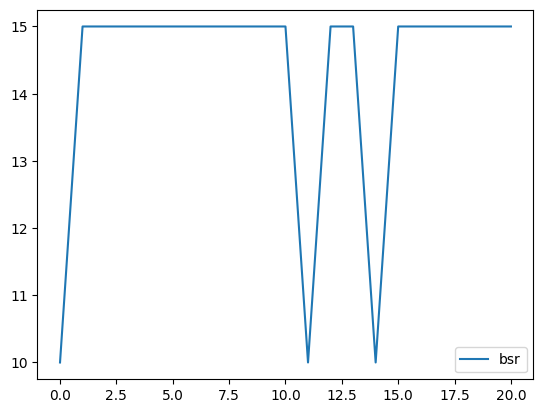

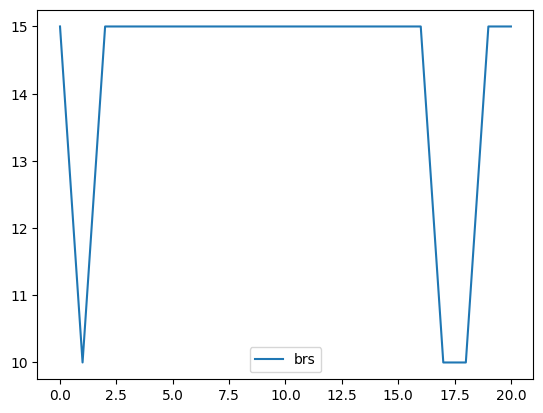

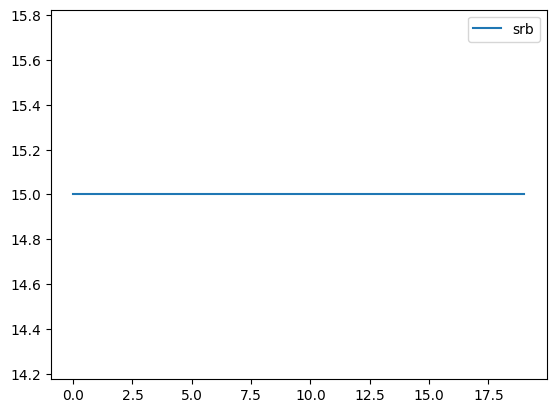

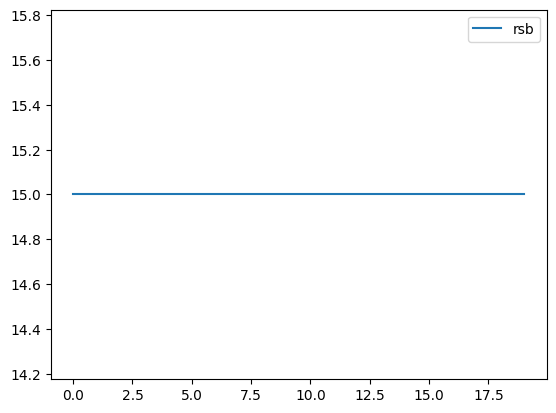

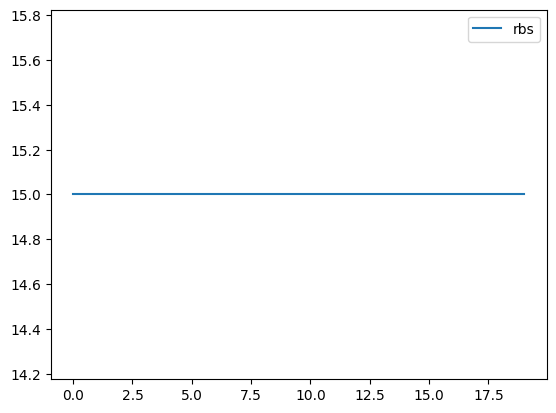

In [4]:
range_size = 100
buffer_size = 40
batch_size = 15
repeats = 3

rng_set = tf.data.Dataset.range(range_size)

sbr = [n.numpy().mean() for n in rng_set.shuffle(buffer_size).batch(batch_size).repeat(repeats)]
bsr = [n.numpy().mean() for n in rng_set.batch(batch_size).shuffle(buffer_size).repeat(repeats)]
brs = [n.numpy().mean() for n in rng_set.batch(batch_size).repeat(repeats).shuffle(buffer_size)]
srb = [n.numpy().mean() for n in rng_set.shuffle(buffer_size).repeat(repeats).batch(batch_size)]
rsb = [n.numpy().mean() for n in rng_set.repeat(repeats).shuffle(buffer_size).batch(batch_size)]
rbs = [n.numpy().mean() for n in rng_set.repeat(repeats).batch(batch_size).shuffle(buffer_size)]

plt.plot(sbr, label="sbr")
plt.legend()
plt.show()
plt.plot(bsr, label="bsr")
plt.legend()
plt.show()
plt.plot(brs, label="brs")
plt.legend()
plt.show()
plt.plot(srb, label="srb")
plt.legend()
plt.show()
plt.plot(rsb, label="rsb")
plt.legend()
plt.show()
plt.plot(rbs, label="rbs")
plt.legend()
plt.show()

sbr = [len(n.numpy()) for n in rng_set.shuffle(buffer_size).batch(batch_size).repeat(repeats)]
bsr = [len(n.numpy()) for n in rng_set.batch(batch_size).shuffle(buffer_size).repeat(repeats)]
brs = [len(n.numpy()) for n in rng_set.batch(batch_size).repeat(repeats).shuffle(buffer_size)]
srb = [len(n.numpy()) for n in rng_set.shuffle(buffer_size).repeat(repeats).batch(batch_size)]
rsb = [len(n.numpy()) for n in rng_set.repeat(repeats).shuffle(buffer_size).batch(batch_size)]
rbs = [len(n.numpy()) for n in rng_set.repeat(repeats).batch(batch_size).shuffle(buffer_size)]

plt.plot(sbr, label="sbr")
plt.legend()
plt.show()
plt.plot(bsr, label="bsr")
plt.legend()
plt.show()
plt.plot(brs, label="brs")
plt.legend()
plt.show()
plt.plot(srb, label="srb")
plt.legend()
plt.show()
plt.plot(rsb, label="rsb")
plt.legend()
plt.show()
plt.plot(rbs, label="rbs")
plt.legend()
plt.show()

In the diagrams above you can see the different effects of applying the 3 methods in different order.
- shuffle, batch, repeat: shuffle only shuffles the first 40 dates, batch splits this and repeat repeats this3 times
    - bad, because values of dates repeat in approximatly same order and batch sizes drops to 10, when not enough elements are left
- batch, shuffle, repeat: repeats approximatly every 3 batches, because batch_size 15 overflows buffer_size 40 after 3 steps
    - bad, but better than sbr
    - less elements in batch
- batch, repeat, shuffle: more random, but some repition, 
    - batch size not constant
- shuffle, repeat, batch: constant batch size, same repition as in sbr
- repeat, shuffle, batch: constant batch size, but kind of increasing values -> ordering of rng_set isn't destructed
- repeat, batch, shuffle: constant batch size, more random but looks like there is some order

**conclusion**: 
- repeat before batch to get constant batch size all the time
- shuffle before repeat not so nice
- shuffle befor batch seems to be better, because then the whole set is shuffled and batched instead of shuffling sorted batches

> *seemingly best order*: repeat().shuffle().batch()
>
> makes sense, since repeat() repeats the set, so we get constant batch sizes, then shuffle can shuffle the whole data set and batch can create the batches

### Using tf.data to load and batch MNIST

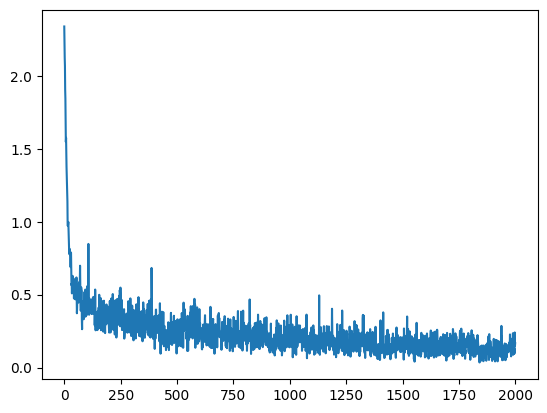

In [17]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# things we really gotta do:
# - normalize the images to [0, 1] (first convert to float)
# - reshape images from (28, 28) to (784,) (although we could do this later!)
# - convert labels to int32 (otherwise tensorflow is gonna be sad :( )

train_images = (train_images.astype(np.float32) / 255.).reshape((-1, 784))
test_images = (test_images.astype(np.float32) / 255.).reshape((-1, 784))

train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

# this is now different
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

train_data = train_data.repeat().shuffle(1152).batch(128)


# training...
mlp = MLP([784, 200, 10], 0.1)
xents = []
it = iter(train_data)

for _ in range(2000):
    imgs, lbls = next(it)
    xents.append(mlp.train(imgs, lbls, 0.2))
    
plt.plot(xents)
plt.show()